In [32]:

import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.plot import show
import numpy as np
import os
import pandas as pd
from shapely.geometry import Point, Polygon
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import gaussian_kde
from matplotlib_scalebar.scalebar import ScaleBar

### Purpose and Description of this Notebook:
This notebook aims to clean and preprocess the Ethiopian Health Facilities dataset Ethiopian Health Facilities.shp.
The cleaning process involves handling missing values, standardizing text fields, and removing duplicates to ensure data consistency and quality.
Additionally, this notebook merges the cleaned Ethiopian Health Facilities dataset with the AddisDatabase AddisDatabase.shp.
The merged dataset will provide a comprehensive view of health facilities in Ethiopia, particularly in Addis Ababa, enabling more accurate analysis and decision-making.


# Data Cleaning
This section handles the cleaning and preprocessing of the Ethiopian health facilities dataset including handling missing values, standardizing text fields, and removing duplicates


In [8]:
# Load the data
ethiopia_health = gpd.read_file('./Ethiopian_health_Facilities/Ethiopian Health Facilities.shp')


# Filter the data to include only Addis Ababa
addis_ababa_health = ethiopia_health[ethiopia_health['admin1Name'] == 'Addis Ababa']

# Clean the data
# 1. Remove rows with missing critical information
addis_ababa_health = addis_ababa_health.dropna(subset=['Type', 'admin1Name', 'Ownership'])

# 2. Standardize text columns
# List of text columns to standardize
text_columns = ['Type', 'admin1Name', 'admin2Name', 'Name', 'admin3Name', 'City', 'Kebele', 'Ownership']

# Standardize each text column
for col in text_columns:
    # Apply basic string cleaning (strip whitespace) to all columns
    addis_ababa_health[col] = addis_ababa_health[col].str.strip()
    # addis_ababa_health[col] = addis_ababa_health[col].str.title()
    
    
    
# 3. Create health facility counts by administrative levels
# Check for duplicates and drop them, keeping only unique entries
duplicate_check = addis_ababa_health.duplicated(keep=False)
if duplicate_check.any():
    print(f"Found and removing {duplicate_check.sum()} duplicate entries")
    # Drop duplicates and keep first occurrence
    addis_ababa_health = addis_ababa_health.drop_duplicates(keep='first')
    print(f"Remaining unique entries: {len(addis_ababa_health)}")

# Create health facility counts
health_counts = addis_ababa_health.groupby(['Type', 'admin1Name', 'admin2Name', 'admin3Name'])\
    .size()\
    .reset_index(name='health_institution_count')\
    .sort_values('health_institution_count', ascending=False)

# 4. Create ownership distribution
ownership_counts = addis_ababa_health.groupby(['admin1Name', 'Ownership'])\
    .size()\
    .reset_index(name='ownership_count')\
    .sort_values('ownership_count', ascending=False)




In [9]:
# Load Addis Ababa shapefile
addis_db = gpd.read_file('../AddisDatabase.shp')

# Drop rows with missing Woreda values
addis_db = addis_db.dropna(subset=['Woreda'])

# Check for duplicates and drop them
duplicate_check = addis_db.duplicated(keep=False)
if duplicate_check.any():
    print(f"Found and removing {duplicate_check.sum()} duplicate entries")
    # Drop duplicates and keep first occurrence
    addis_db = addis_db.drop_duplicates(keep='first')
    print(f"Remaining unique entries: {len(addis_db)}")

# Convert CRS to EPSG:4326 (WGS84)
addis_db = addis_db.to_crs(epsg=4326)

In [11]:

addis_health_merged = gpd.sjoin(addis_db, addis_ababa_health, how='left', predicate='intersects')
addis_health_merged

,Woreda,Sub_City,City_left,popden,Area,geometry,index_right,Id,Name,Latitude,...,Type,admin3Name,admin3Pcod,admin2Name,admin2Pcod,admin1Name,admin1Pcod,City_right,Kebele,Status
0,W01,Yeka,Addis,159.881253,394.192424,"POLYGON ((38.78806 9.08043, 38.78802 9.08041, ...",15525.0,1029902.0,Fraol pharmacy,9.054760,...,Pharmacy,Yeka,ET140107,Region 14,ET1401,Addis Ababa,ET14,Addis Ababa,None,Approved
0,W01,Yeka,Addis,159.881253,394.192424,"POLYGON ((38.78806 9.08043, 38.78802 9.08041, ...",22939.0,1029082.0,Kenean Medium Clinic,9.062969,...,Clinic,Yeka,ET140107,Region 14,ET1401,Addis Ababa,ET14,Addis Ababa,None,Approved
0,W01,Yeka,Addis,159.881253,394.192424,"POLYGON ((38.78806 9.08043, 38.78802 9.08041, ...",7711.0,1044399.0,Biniyam Medium Clinic,9.064228,...,Clinic,Yeka,ET140107,Region 14,ET1401,Addis Ababa,ET14,Addis Ababa,None,Approved
0,W01,Yeka,Addis,159.881253,394.192424,"POLYGON ((38.78806 9.08043, 38.78802 9.08041, ...",39569.0,1029099.0,Yewodekutn Ansu Medium Clinic,9.067579,...,Clinic,Yeka,ET140107,Region 14,ET1401,Addis Ababa,ET14,Addis Ababa,None,Approved
0,W01,Yeka,Addis,159.881253,394.192424,"POLYGON ((38.78806 9.08043, 38.78802 9.08041, ...",27656.0,1029104.0,Meri Ferensaye Medium Clinic,9.056789,...,Clinic,Yeka,ET140107,Region 14,ET1401,Addis Ababa,ET14,Addis Ababa,None,Approved
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,10,Addis ketema,Addis,52.491053,125.375800,"POLYGON ((38.71495 9.05432, 38.71504 9.05432, ...",10342.0,1029958.0,Daniya Pharmacy,9.041535,...,Pharmacy,Addis Ketema,ET140108,Region 14,ET1401,Addis Ababa,ET14,Addis Ababa,12,Approved
115,10,Addis ketema,Addis,52.491053,125.375800,"POLYGON ((38.71495 9.05432, 38.71504 9.05432, ...",39684.0,1057890.0,Yinatu pharmacy,9.041891,...,Pharmacy,Addis Ketema,ET140108,Region 14,ET1401,Addis Ababa,ET14,Addis Ababa,None,Approved
115,10,Addis ketema,Addis,52.491053,125.375800,"POLYGON ((38.71495 9.05432, 38.71504 9.05432, ...",28059.0,1030275.0,Miback Pharmacy,9.042422,...,Pharmacy,Addis Ketema,ET140108,Region 14,ET1401,Addis Ababa,ET14,Addis Ababa,10,Approved
115,10,Addis ketema,Addis,52.491053,125.375800,"POLYGON ((38.71495 9.05432, 38.71504 9.05432, ...",14306.0,1030209.0,Ethio Marble Primarly Clinic,9.054726,...,Clinic,Gulele,ET140110,Region 14,ET1401,Addis Ababa,ET14,Addis Ababa,10,Approved


In [15]:
addis_health_merged = addis_health_merged[['Woreda', 'Sub_City', 'popden', 'Area', 'Name', 'Ownership', 'Type', 'Status', 'geometry']]

# Data Engineering 
Here we create additional columns of number of health institutions by type, ownership, and status



In [ ]:
# Step 1: Count total number of health institutions by Sub_City and Woreda
count_total = addis_health_merged.groupby(['Woreda', 'Sub_City', 'popden', 'Area', 'geometry']).size().reset_index(name='number_of_health_inst')

# Step 2: Pivot Ownership, Type, and Status into counts
pivot_ownership = pd.pivot_table(addis_health_merged, index=['Woreda', 'Sub_City', 'popden', 'Area', 'geometry'], columns='Ownership', aggfunc='size', fill_value=0)
pivot_type = pd.pivot_table(addis_health_merged, index=['Woreda', 'Sub_City', 'popden', 'Area', 'geometry'], columns='Type', aggfunc='size', fill_value=0)
pivot_status = pd.pivot_table(addis_health_merged, index=['Woreda', 'Sub_City', 'popden', 'Area', 'geometry'], columns='Status', aggfunc='size', fill_value=0)

# Step 3: Combine all into a condensed dataset
condensed_df = count_total \
    .set_index(['Woreda', 'Sub_City', 'popden', 'Area', 'geometry']) \
    .join([pivot_ownership, pivot_type, pivot_status]) \
    .reset_index()


In [27]:
condensed_df.columns

Index(['Woreda', 'Sub_City', 'popden', 'Area', 'geometry',
       'number_of_health_inst', 'Other Government', 'Private Not for profit',
       'Private for profit', 'Public/Government', 'Clinic', 'Health Center',
       'Health Post', 'Home-Based Care Service', 'Hospital', 'ImagingCenters',
       'Laboratories', 'Medical Office Practice',
       'Medical Office Practice,Medical Office Practice', 'Other',
       'Other,Home-Based Care Service', 'Pharmacy', 'Specialty Center',
       'Specialty Clinic', 'Approved', 'Denied'],
      dtype='object')

# Data Data Visualization
Task for Tarik- Here we map the popdn heat map by placing the rank of each of the number of institutions columns including popden at subcity and woreda level. So you basically produce 2 maps one at sub_city and another at woreda level that summarize the heat map of pop_den and the number of institutions in a form of ranking.


/opt/homebrew/anaconda3/envs/addis-env/lib/python3.11/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(


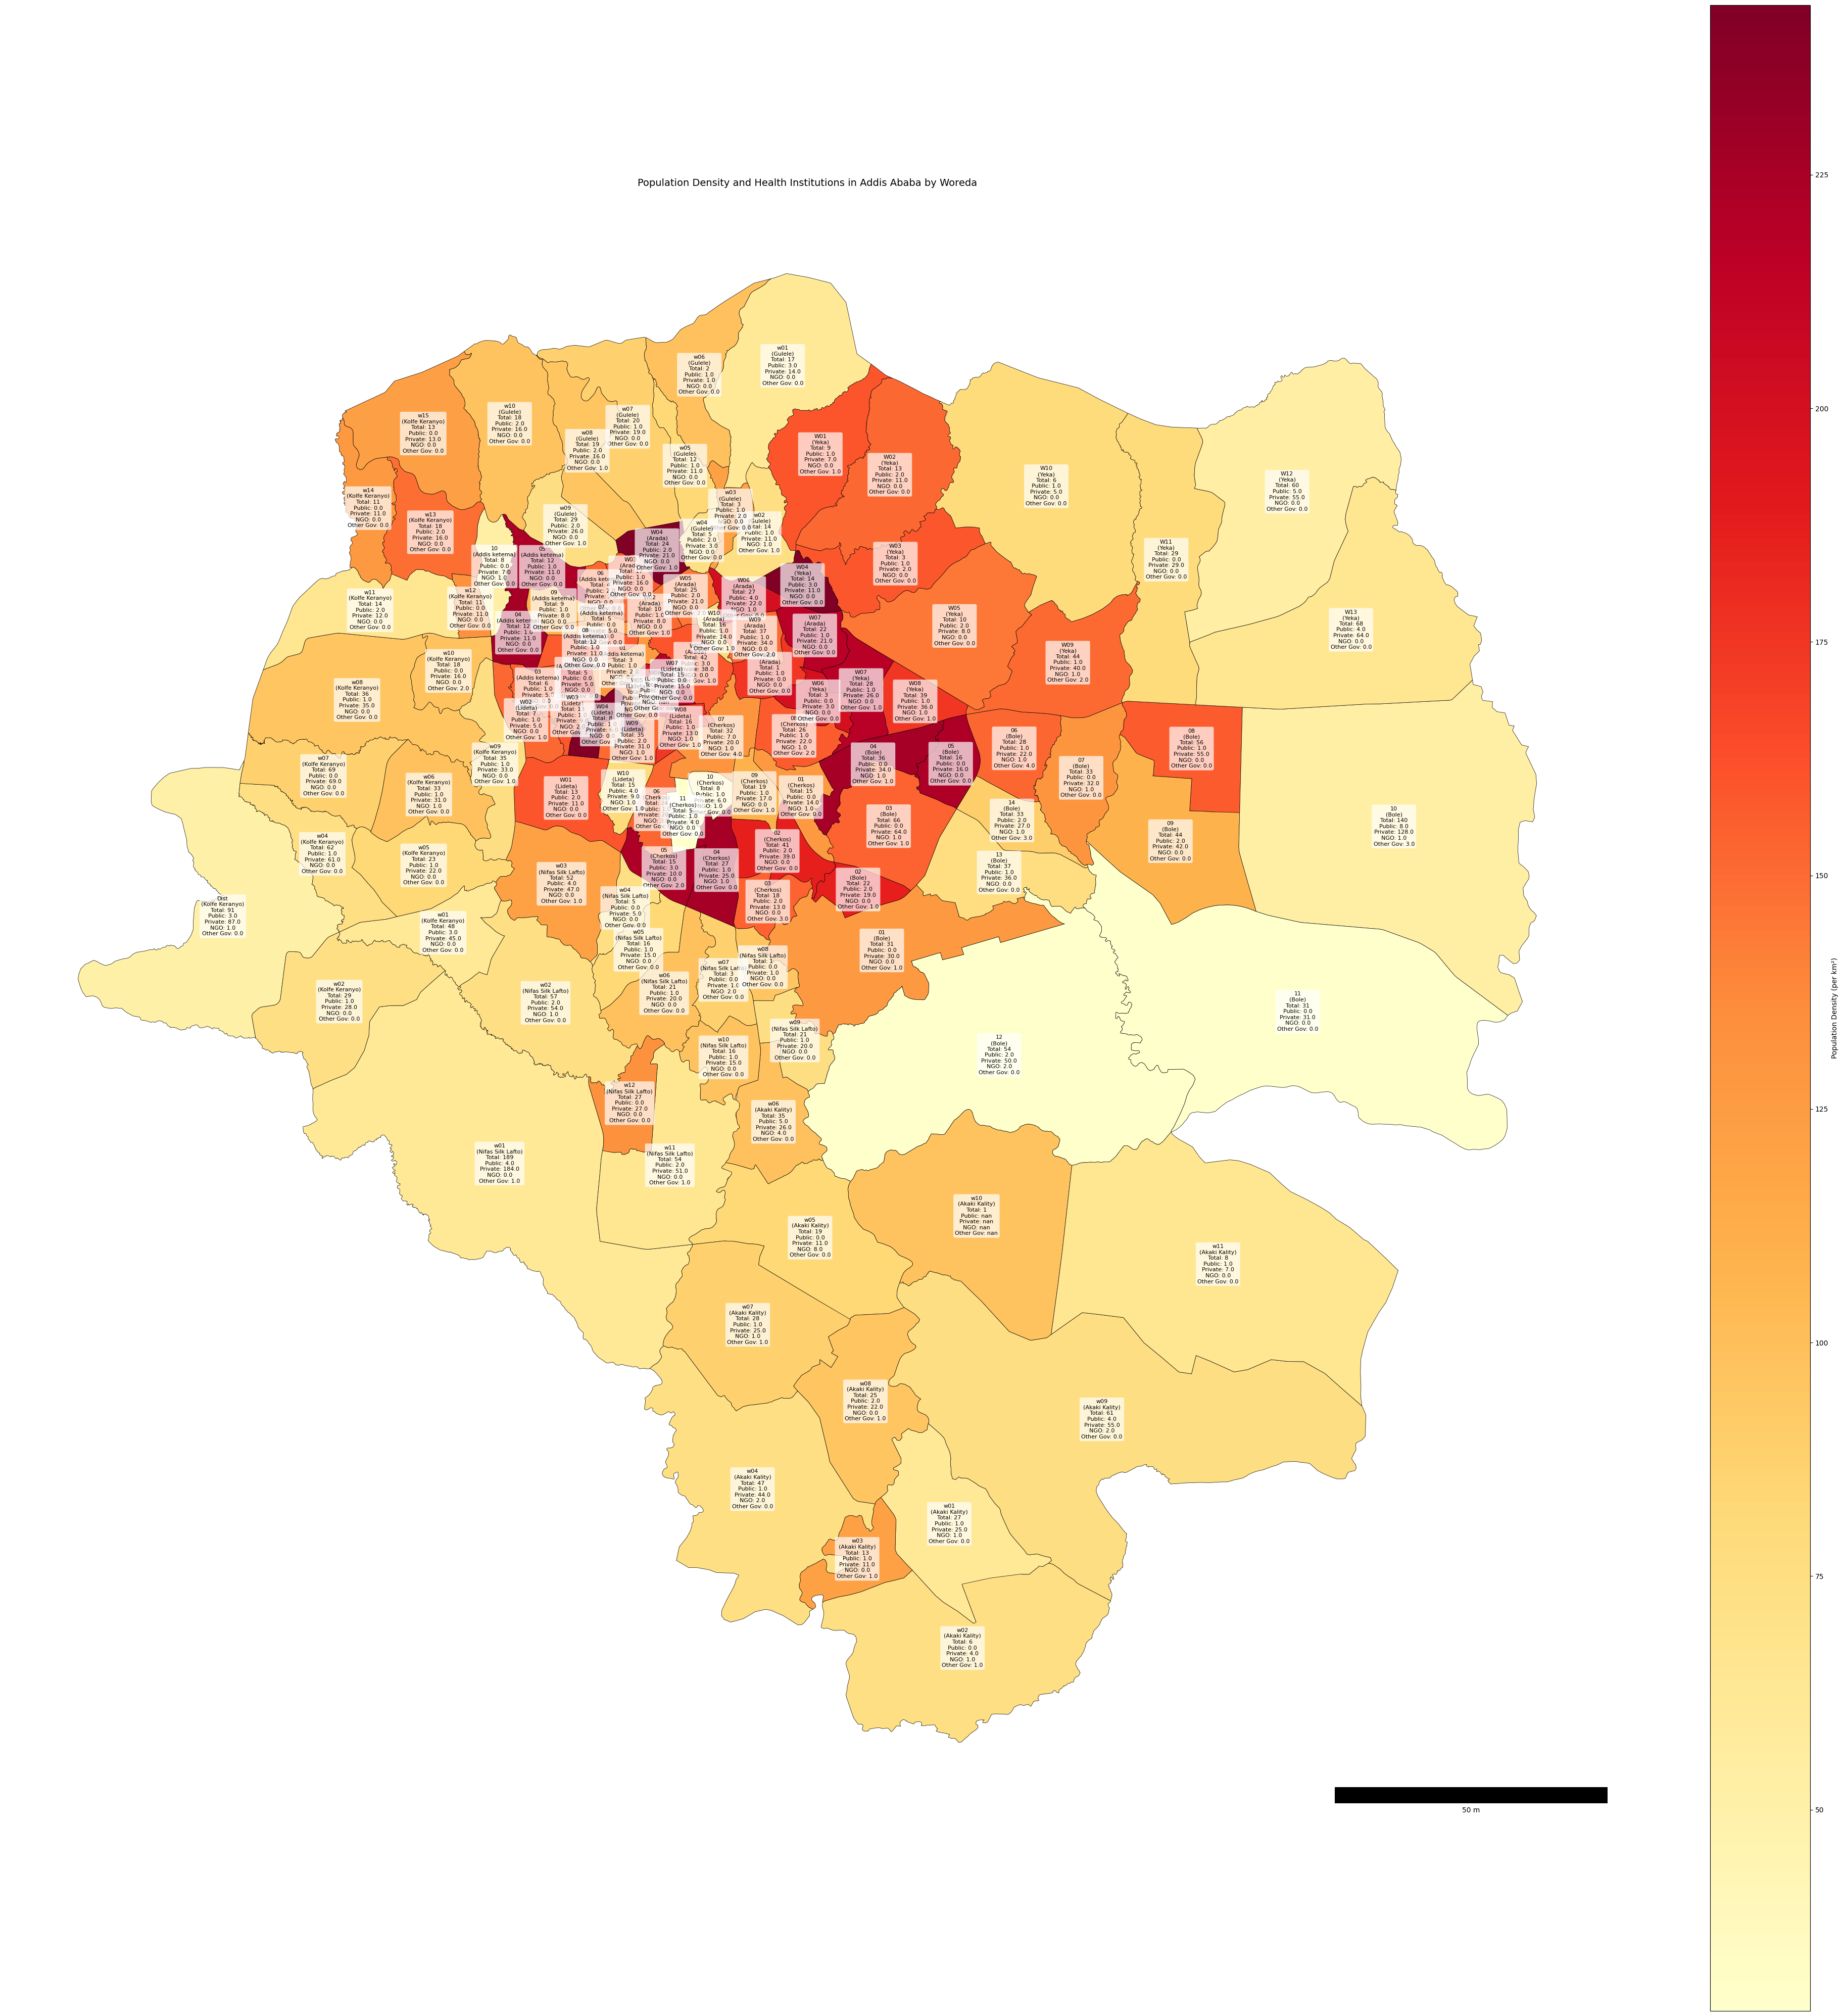

In [38]:
# Create a single figure for population density map
fig, ax = plt.subplots(figsize=(40, 40))

# Convert to GeoDataFrame if not already
if not isinstance(condensed_df, gpd.GeoDataFrame):
    condensed_df = gpd.GeoDataFrame(condensed_df, geometry='geometry')

# Plot population density at Woreda level
condensed_df.plot(
    column='popden',
    ax=ax,
    legend=True,
    cmap='YlOrRd',
    missing_kwds={'color': 'lightgrey'},
    legend_kwds={'label': 'Population Density (per km²)'},
    edgecolor='black',  # Add black border for each woreda
    linewidth=0.5       # Set border width
)

# Add title and remove axis
ax.set_title('Population Density and Health Institutions in Addis Ababa by Woreda', fontsize=14, pad=20)
ax.axis('off')

# Add woreda, subcity labels and institution count with ownership breakdown
for idx, row in condensed_df.iterrows():
    # Get the centroid of each woreda
    centroid = row.geometry.centroid
    
    # Create ownership breakdown text
    ownership_text = ""
    if 'Public/Government' in row:
        ownership_text += f"Public: {row['Public/Government']}\n"
    if 'Private for profit' in row:
        ownership_text += f"Private: {row['Private for profit']}\n"
    if 'Private Not for profit' in row:
        ownership_text += f"NGO: {row['Private Not for profit']}\n"
    if 'Other Government' in row:
        ownership_text += f"Other Gov: {row['Other Government']}"
    
    # Add the woreda name, subcity and institution count with ownership breakdown
    label_text = f"{row['Woreda']}\n({row['Sub_City']})\nTotal: {row['number_of_health_inst']}\n{ownership_text}"
    
    ax.text(
        centroid.x, 
        centroid.y, 
        label_text,
        fontsize=8,
        ha='center',
        va='center',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.3')
    )

scale_bar = ScaleBar(1, units='km', location='lower right')
ax.add_artist(scale_bar)

plt.tight_layout()
plt.show()
